In [1]:
import tensorflow as tf
print(tf.__version__)

1.13.1


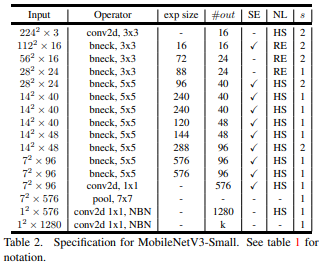

## testing for online resource (only for tf>=1.13)
https://github.com/Bisonai/mobilenetv3-tensorflow/blob/master/

In [ ]:
from mobilenetv3_factory import build_mobilenetv3
model = build_mobilenetv3(
    "large",
    input_shape=(224, 224, 3),
    num_classes=1001,
    width_multiplier=1.0,
)
model.summary()

In [2]:
from layers import Bneck

layer = Bneck(
      out_channels=16,
      exp_channels=16,
      kernel_size=3,
      stride=1,
      use_se=True,
      act_layer="relu",
     )

x = tf.keras.Input((5,5,16), name="x")
out = layer(x)
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 5, 5, 16)          0         
_________________________________________________________________
Bneck (Bneck)                (None, 5, 5, 16)          976       
Total params: 976
Trainable params: 880
Non-trainable params: 96
_________________________________________________________________


## our block

In [3]:
def BatchNormalization(inputs, name):
    return tf.keras.layers.BatchNormalization(momentum=0.99, name=name) (inputs)

def ConvNormAct(inputs, 
                filters, 
                kernel_size=3, 
                stride=1, 
                padding=0, 
                use_bn=False, 
                act_layer="relu", 
                use_bias=True, 
                l2_reg=1e-5, 
                name="ConvNormAct"):
    
    in_channels = inputs.get_shape()[-1]
    
    out = inputs
    
    if padding > 0:
        out = tf.keras.layers.ZeroPadding2D(padding=padding,
                                            name=f"{name}/padding",) (out)
    
    out = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=stride,
            name=f"{name}/conv{kernel_size}x{kernel_size}",
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            use_bias=use_bias,
        ) (out)
    
    if use_bn:
        out = BatchNormalization(out, name=f"{name}/bn")
    
    
    if act_layer:
        _available_activation = {
            "relu": tf.keras.layers.ReLU(name=f"{name}/ReLU"),
            #"hswish": HardSwish(name="Depthwise/HardSwish"),
            "softmax": tf.keras.layers.Softmax(name=f"{name}/Softmax"),
        }
        out = _available_activation.get(act_layer) (out)
    
    return out

"""
x = tf.keras.Input((5,5,3), name="x")
out = ConvNormAct(x, 16, 3, 2, 1, True, "relu", False, 1e-5)
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()
"""

'\nx = tf.keras.Input((5,5,3), name="x")\nout = ConvNormAct(x, 16, 3, 2, 1, True, "relu", False, 1e-5)\nmodel = tf.keras.Model(inputs=[x], outputs=[out], name="test")\nmodel.summary()\n'

In [4]:
def GlobalAveragePooling2D(inputs, name):
    pool_size = inputs.get_shape()[1:3]
    gap = tf.keras.layers.AveragePooling2D(
        pool_size=pool_size,
        name=f"{name}/AvgPool{pool_size[0]}x{pool_size[1]}")
    return gap(inputs)
    
def SEBottleneck(inputs, 
                 reduction=4,
                 l2_reg=1e-2,
                 name="SEBottleneck"):
    batch_size = inputs.get_shape()[0]
    in_channels = inputs.get_shape()[-1]
    
    out = inputs
    
    gap = GlobalAveragePooling2D(out, name=f"{name}/gap")
    
    filters_squeeze = in_channels//reduction if in_channels//reduction > 0 else 1    
    conv1 = ConvNormAct(inputs=gap,
                        filters=int(filters_squeeze), 
                        kernel_size=1, 
                        use_bn=False,
                        act_layer="relu", 
                        use_bias=False, 
                        l2_reg=l2_reg, 
                        name=f"{name}/Squeeze")
    
    conv2 = ConvNormAct(inputs=conv1,
                        filters=int(in_channels), 
                        kernel_size=1, 
                        use_bn=False, 
                        act_layer="relu",
                        use_bias=False, 
                        l2_reg=l2_reg, 
                        name=f"{name}/Excite")
    
    return tf.keras.layers.Multiply(name=f"{name}/Mul") ([inputs, conv2]) 

"""
x = tf.keras.Input((5,5,16), name="x")
out = SEBottleneck(x, name="SEB")
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()
"""

'\nx = tf.keras.Input((5,5,16), name="x")\nout = SEBottleneck(x, name="SEB")\nmodel = tf.keras.Model(inputs=[x], outputs=[out], name="test")\nmodel.summary()\n'

In [5]:
def myBneck(inputs, 
            out_channels, 
            exp_channels, 
            kernel_size, 
            stride, 
            use_se, 
            act_layer,
            l2_reg=1e-5,
            name="myBneck"):
    
    in_channels = inputs.get_shape()[-1]
    
    out = inputs
    
    # Expand -----------------
    out = ConvNormAct(
        inputs=out,
        filters=exp_channels,
        kernel_size=1,
        use_bn=True,
        act_layer=act_layer,
        use_bias=False,
        l2_reg=l2_reg,
        name=f"{name}/Expand",
    )
    
    # Depthwise -----------------
    dw_padding = (kernel_size - 1) // 2
    out = tf.keras.layers.ZeroPadding2D(
        padding=dw_padding,
        name=f"{name}/Depthwise/Padding{dw_padding}x{dw_padding}",
    ) (out)
    
    out = tf.keras.layers.DepthwiseConv2D(
        kernel_size=kernel_size,
        strides=stride,
        name=f"{name}/Depthwise/DWConv{kernel_size}x{kernel_size}",
        depthwise_regularizer=tf.keras.regularizers.l2(l2_reg),
        use_bias=False,
    ) (out)
    
    out = BatchNormalization(out, name=f"{name}/Depthwise/bn")
    
    if use_se:
        out = SEBottleneck(inputs=out,
                           l2_reg=l2_reg,
                           name=f"{name}/Depthwise/SEBottleneck")

    _available_activation = {
        "relu": tf.keras.layers.ReLU(name=f"{name}/Depthwise/ReLU"),
        #"hswish": HardSwish(name="Depthwise/HardSwish"),
    }
    out = _available_activation.get(act_layer) (out)
    
    # Project -----------------
    out = ConvNormAct(
        inputs=out,
        filters=out_channels,
        kernel_size=1,
        use_bn=True,
        act_layer=None,
        use_bias=False,
        l2_reg=l2_reg,
        name=f"{name}/Project",
    )
    
    if stride == 1 and in_channels == out_channels:
        out = tf.keras.layers.Add(name=f"{name}/Add") ([inputs, out])
    
    return out

In [6]:
x = tf.keras.Input((5,5,16), name="x")
#out = SEBottleneck(x, name="SEB")
out = myBneck(x, 16, 16, 3, 1, True, "relu")
model = tf.keras.Model(inputs=[x], outputs=[out], name="test")
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 5, 5, 16)     0                                            
__________________________________________________________________________________________________
myBneck/Expand/conv1x1 (Conv2D) (None, 5, 5, 16)     256         x[0][0]                          
__________________________________________________________________________________________________
myBneck/Expand/bn (BatchNormali (None, 5, 5, 16)     64          myBneck/Expand/conv1x1[0][0]     
__________________________________________________________________________________________________
myBneck/Expand/ReLU (ReLU)      (None, 5, 5, 16)     0           myBneck/Expand/bn[0][0]          
__________________________________________________________________________________________________
myBneck/De